In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sunpy.map import Map

In [2]:
class sharp:

      def __init__(self, filename):
            self.filename = filename

            hmi_p = filename + ".Bp.fits"
            hmi_t = filename + ".Bt.fits"
            hmi_r = filename + ".Br.fits"
            err_p = filename + ".Bp_err.fits"
            err_t = filename + ".Bt_err.fits"
            err_r = filename + ".Br_err.fits"

            self.Bx = Map(hmi_p).data.transpose()
            self.By = -Map(hmi_t).data.transpose()
            self.Bz = Map(hmi_r).data.transpose()
            self.Bx_err = Map(err_p).data.transpose()
            self.By_err = -Map(err_t).data.transpose()
            self.Bz_err = Map(err_r).data.transpose()

            self.hmi_cube = np.stack([self.Bx, self.By, self.Bz], axis=-1)
            self.err_cube = np.stack([self.Bx_err, self.By_err, self.Bz_err], axis=-1)
            
            self.meta = Map(hmi_p).meta

            # 2 * pi * R_sun (Mm) = 360 (deg)
            Mm_per_deg = (2 * np.pi * 696)/360

            # cdelt1 = deg_per_pixel in x
            # cdelt2 = deg_per_pixel in y
            # Mm_per_pixel = Mm_per_deg * deg_per_pixel
            self.dx_Mm_per_pixel = Mm_per_deg * self.meta['cdelt1']
            self.dy_Mm_per_pixel = Mm_per_deg * self.meta['cdelt2']

            self.Lx_pixel, self.Ly_pixel = self.Bx.shape
            
            self.Lx_Mm, self.Ly_Mm = self.Lx_pixel * self.dx_Mm_per_pixel, self.Ly_pixel * self.dy_Mm_per_pixel
            

            self.x = np.linspace(-self.Lx_Mm/2, self.Lx_Mm/2, self.Lx_pixel+1)
            self.y = np.linspace(-self.Ly_Mm/2, self.Ly_Mm/2, self.Ly_pixel+1)
            
      def info(self):
            print(f'(Lx, Ly) in pixel = {(self.Lx_pixel, self.Ly_pixel)}')
            print(f'(Lx, Ly) in Mm = ({self.Lx_Mm:.2f}, {self.Ly_Mm:.2f})')
            return self.meta

      def plot(self):
            xs = 12.0
            ys = 4.0

            xmin=min(self.x)
            xmax=max(self.x)
            ymin=min(self.y)
            ymax=max(self.y)

            plt.close()
            fig=plt.figure(figsize=(xs,ys))
            ax1=fig.add_axes((0.08,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax2=fig.add_axes((0.4,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax3=fig.add_axes((0.72,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            cax1=fig.add_axes((0.08,0.15,0.25,0.05))
            cax2=fig.add_axes((0.4,0.15,0.25,0.05))
            cax3=fig.add_axes((0.72,0.15,0.25,0.05))

            vmin=-3000.0 
            vmax=3000.0
            
            im1=ax1.pcolormesh(self.x,self.y,self.Bx.transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im2=ax2.pcolormesh(self.x,self.y,self.By.transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im3=ax3.pcolormesh(self.x,self.y,self.Bz.transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')

            cbar1=plt.colorbar(im1,cax=cax1,orientation='horizontal')
            cbar2=plt.colorbar(im2,cax=cax2,orientation='horizontal')
            cbar3=plt.colorbar(im3,cax=cax3,orientation='horizontal')
            
            ax1.set_title('Bx [G]')
            ax1.set_xlabel('x [Mm]')
            ax1.set_ylabel('y [Mm]')
            
            ax2.set_title('By [G]')
            ax2.set_xlabel('x [Mm]')
            ax2.set_ylabel('y [Mm]')
            
            ax3.set_title('Bz [G]')
            ax3.set_xlabel('x [Mm]')
            ax3.set_ylabel('y [Mm]')


In [3]:
data = sharp('/home/tensor/workspace/pinn_study/_data/12673_20170905_202400/hmi.sharp_cea_720s.7115.20170905_202400_TAI')

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]


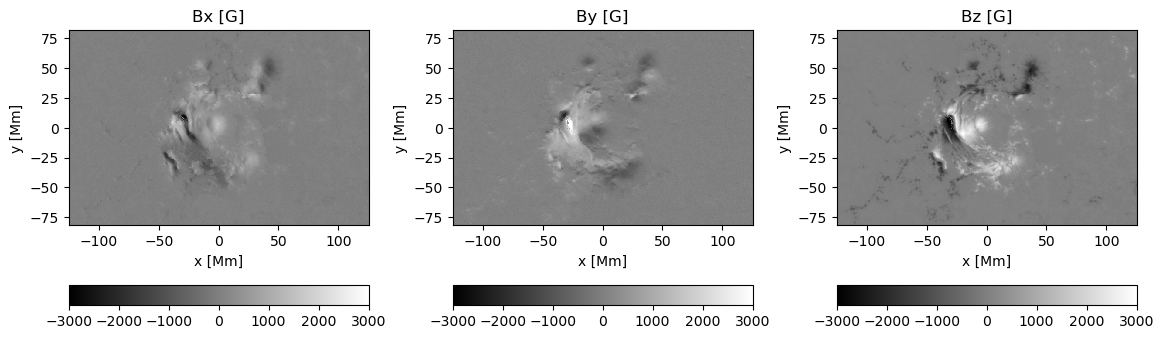

In [4]:
data.plot()

In [6]:
import os
import logging
from datetime import datetime
from astropy.nddata import block_reduce

from nf2.data.loader import load_hmi_data
from nf2.train.trainer import NF2Trainer

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

# JSON
base_path = '/home/tensor/workspace/pinn_study/_run/sharp'
data_path = '/home/tensor/workspace/pinn_study/_data/12673_20170905_202400/hmi.sharp_cea_720s.7115.20170905_202400_TAI'
meta_path = None

d_slice = None
bin = 2

height = 160
spatial_norm = 160
b_norm = 2500

meta_info = None
dim = 256
positional_encoding = False
use_potential_boundary = True
potential_strides = 4
use_vector_potential = False
lambda_div = 1e-1
lambda_ff = 1e-1
decay_iterations = 50000
device = None
work_directory = None

total_iterations = 100000
batch_size = 10000
log_interval = 10000
validation_interval = 10000
num_workers = 4

# init logging
os.makedirs(base_path, exist_ok=True)
log = logging.getLogger()
log.setLevel(logging.INFO)
for hdlr in log.handlers[:]:  # remove all old handlers
    log.removeHandler(hdlr)
log.addHandler(logging.FileHandler("{0}/{1}.log".format(base_path, "info_log")))  # set the new file handler
log.addHandler(logging.StreamHandler())  # set the new console handler

start_time = datetime.now()
hmi_p = f"{data_path}.Bp.fits"
err_p = f"{data_path}.Bp_err.fits"
hmi_r = f"{data_path}.Br.fits"
err_r = f"{data_path}.Br_err.fits"
hmi_t = f"{data_path}.Bt.fits"
err_t = f"{data_path}.Bt_err.fits"

file_id = os.path.basename(hmi_p).split('.')[3]
base_path = os.path.join(base_path, 'dim%d_bin%d_pf%s_ld%s_lf%s' % (
        dim, bin, str(use_potential_boundary), lambda_div, lambda_ff))

base_path = os.path.join(base_path, f'{file_id}')

# print(base_path)

log.info(f'START: {file_id}')

# load data cube
b_cube, error_cube, meta_info = load_hmi_data([hmi_p, err_p, hmi_r, err_r, hmi_t, err_t])

if d_slice is not None:
    b_cube = b_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
    error_cube = error_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]

if bin > 1:
    b_cube = block_reduce(b_cube, (bin, bin, 1), np.mean)
    error_cube = block_reduce(error_cube, (bin, bin, 1), np.mean)

trainer = NF2Trainer(base_path, b_cube, error_cube, height, spatial_norm, b_norm, 
                     meta_info=meta_info, dim=dim, positional_encoding=positional_encoding, 
                     meta_path=meta_path, use_potential_boundary=use_potential_boundary, 
                     potential_strides=potential_strides, use_vector_potential=use_vector_potential,
                     lambda_div=lambda_div, lambda_ff=lambda_ff, decay_iterations=decay_iterations,
                     device=device, work_directory=work_directory)

# Train
trainer.train(total_iterations, batch_size, 
              log_interval=log_interval, validation_interval=validation_interval, 
              num_workers=num_workers)
log.info(f'TOTAL RUNTIME: {datetime.now() - start_time}')

START: 20170905_202400_TAI
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.
Configuration:
dim: 256, lambda_div: 0.100000, lambda_ff: 0.100000, decay_iterations: 50000, potential: True, vector_potential: False, 
Using device: cuda (gpus 1) ['NVIDIA GeForce RTX 3060']
Potential Boundary: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
Resuming training from iteration 100000
Training already finished!
TOTAL RUNTIME: 0:00:02.426165


In [ ]:
import torch
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.vtk import save_vtk

model_path = base_path + '/extrapolation_result.nf2'
vtk_path = base_path + '/extrapolation_result.vtk'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
b = load_cube(model_path, device, progress=True)
save_vtk(b, vtk_path, 'B')